# Домашнее задание 3

Это домашнее задание по материалам 6-8 недели семестра (6-8 лекции и 5-7 семинары). Дедлайн по отправке - 23:59 12 ноября.

- Домашнее задание выполняется в этом же Jupyter Notebook'e.

- Файл необходимо переименовать: __Номер группы_Фамилия_Имя__ (без пробелов в начале и конце). Пример: __Б05-100_Иванов_Иван__.

- ДЗ нужно отправлять на __OptimizationHomework@yandex.ru__. Тема письма: __МФТИ_номер задания__ (без пробелов в начале и конце). Для данного ДЗ тема письма: __МФТИ_3__.

- Для решения можно использовать Google Colab, но присылать нужно не ссылку на Colab, а готовый notebook и все необходимые дополнительные файлы.

- Решение каждой задачи/пункта задачи поместите после условия.

- Не забывайте добавлять необходимые пояснения и комментарии.

- В финальной версии, которая будет отправлена на проверку, должны быть удалены все отладочные артефакты. Под таким артефактами подразумеваются любые выводы ячеек, которые никак не прокоментированы в тексте, а также любой массовый/длинный технический вывод (даже если он прокомментирован в тексте).

- При полном запуске решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок.

- Максимальный балл за задание 120. Для получения полного балла нужно набрать 100. Баллы вниз не округляются.

- Часть задач помечена $\triangle$. Они также входят в максимальный балл за задание, а значит являются обязательными для получения максимальной оценки, но мы считаем, что достаточно выполнить задания без $\triangle$, чтобы вникнуть в основные вещи, происходящие в соотвествующей части задания.

Желаем успехов!

### Часть 1. Снова логистическая регрессия

Рассмотрим задачу минимизации эмпирического риска (да-да, machine learning):
\begin{equation}
\min_{w \in \mathcal{X} \subset \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i),
\end{equation}
где $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ - функция потерь, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ - модель, $w$ - параметры модели, $\{x_i, y_i\}_{i=1}^n$ - выборка данных из векторов признаков $x_i \in \mathbb{R}^x$ и меток $y_i \in \mathbb{R}$.

Используем линейную модель $g(w, x) = w^T x$ и логистическую/сигмоидную функцию потерь: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Важно: $y$ должен принимать значения $-1$ или $1$__). Полученная задача называется задачей логистической регрессии. 

В качестве множества $\mathcal{X}$ возьмем $\ell_1$-шар с центром в 0 и радиуса $R$ (параметр, которые можно менять): $\mathcal{X} =\{x \in \mathbb{R}^d \mid \| x \|_1 \leq R \}$.

__Отличия от прошлого домашнего задания:__ убрали регуляризатор, добавили множество $\mathcal{X}$.

Градиент для нашей целевой функции:
$$
\frac{1}{n} \sum_{i=1}^n \frac{-y_i x_i}{1 + \exp(y_i w^Tx_i)}.
$$
В качестве константы Липшица нашей целевой функции можно брать $L = \frac{1}{4n} \sum\limits_{i=1}^n \| x_i \|^2_2$.

К заданию приложен датасет _mushrooms_. С помощью следующего кода сформируйте матрицу $X$ и вектор $y$, в которой и будет храниться выборка $\{x_i, y_i\}_{i=1}^n$:

In [1]:
dataset = "mushrooms.txt"
#файл должен лежать в той же деректории, что и notebook

In [2]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Поменяем вектор $y$, чтобы $y_i$ принимали значения $-1$ и $1$. Вы также можете сделать дополнительную предобработку данных (приемами из машинного обучения), но это никак дополнительно не оценивается.

In [3]:
y = 2 * y - 3

Разделим данные на две части: обучающую и тестовую.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$. Реализуйте в коде подсчет значения и градиента нашей целевой функции ($X$, $y$ лучше подавать в качестве параметра, чтобы была возможность их менять, а не только подставлять фиксированные $X_{train}$, $y_{train}$). Можно использовать как библиотеку ``numpy``, так и библиотеки ``autograd``, ``pytorch``, ``jax``.

In [5]:
import functools
import torch
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.1, palette='Set1')
%matplotlib inline

In [6]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [7]:
features_amount = X_train.shape[1]
sample_size = X_train.shape[0]

L = (1 / (4 * sample_size)) * torch.square(torch.linalg.norm(X_train))

In [8]:
def f(w, X=X_train, y=y_train):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))


def grad_f(w, X=X_train, y=y_train):
    return torch.func.grad(f, argnums=0)(w, X, y).data

__Задача 1. (всего 33 балла)__ Так как мы теперь решаем задачу оптимизации на шаре, необходимы методы, учитывающие это.

__а). (3 балла)__ Для $\ell_1$-шара с центром в 0 и радиуса $R$ найдите выражение для решения задачи линейной оптимизации при заданном векторе $g \in \mathbb{R}^d$:
$$
s^* = \arg \min_{s \in \mathcal{X}} \langle s, g \rangle.
$$

Формально обоснуйте свой ответ, например, можно (необязательно именно так) использовать условия ККТ.

Б.0.0. будем рассматривать $x \neq 0_d $ так как в нуле $\ell_1$ норма не дифферинцируема, а целевая функция будет просто равна нулю, что, очевидно, не минимальное значение.  
Будем использовать условия ККТ. В их обозначениях имеем:
\begin{align*}
      f_0(x) = \langle x, g \rangle, \\
      f_1(x) = || x ||_1 - R.
\end{align*}
1. Найдем градиенты функций:
    1. $\nabla f_0 = g $
    2. $\nabla f_1 = sign(x) \Leftrightarrow \nabla f_1^i = sign(x_i) .$
2. Тогда сами условия ККТ будут выглядеть так:
    \begin{align*}
          || x^* ||_1 - R \leq 0, \\
          \lambda^* \geq 0, \\
          \lambda^* (|| x^* ||_1 - R) = 0, \\
          g + \lambda^* sign(x^*) = 0.
    \end{align*}
3. Будем рассматривать случаи:
    1. При $\lambda  = 0$ тривиально и верно только при $g = 0.$
    2. При $\lambda \succ 0 \hookrightarrow || x^* ||_1 = R \Rightarrow -sign(g_i) \sum_{i=1}^{d} x_i^* = R$ - переход следует из условия $sign(x^*) = sign(-\frac{g_i}{\lambda}) = -sign(g_i).$
4. На лекции утверждалось, что $x^* = (0, \ldots, 0, -sign(g_i), 0, \ldots, 0)$, где $i$ - индекс максимальной по модулю компоненты вектора $g.$ Такой $x^*$ действительно подходит под полученное из условий ККТ, значит его и будем использовать в качестве выражения для решения задачи линейной оптимизации.

__а). (3 балла)__ Реализуйте отдельно решение задачи линейной оптимизации из предыдущего пункта (радиус шара $R$ лучше передавать в качестве параметра). Реализуйте метод Франк-Вульфа для нашей задачи. Для заданий далее может понадобиться возможность замерять время работы метода. Советуем также следующим образом брать шаг в алгоритме: если итерации нумеруются с 0, то $\gamma = \frac{2}{k+3}$, если итерации нумеруются с 1, то $\gamma = \frac{2}{k+2}$.

In [9]:
def linear_minimization(g, R):
    i = torch.argmax(torch.abs(g))
    e_i = torch.zeros_like(g)
    e_i[i] = 1
    s = -R * torch.sign(g[i]) * e_i
    return s


def gap(grad, w, R):
    y = linear_minimization(grad_f(w), R)
    return torch.dot(grad(w), w - y)


def frank_wolfe(grad, x_0, R, eps, mode='gap(w^k)'):
    
    errors = []
    x_k = x_0.clone().detach()
    k = 0

    while k == 0 or (gap(grad, x_k, R) > eps):
        s_k = linear_minimization(grad(x_k), R)
        gamma_k = 2 / (k + 3)
        x_k = (1 - gamma_k) * x_k + gamma_k * s_k
        errors.append(gap(grad, x_k, R))
        k += 1
        
    return x_k, errors

__б). (5 баллов)__ Решите задачу оптимизации на обучающей выборке с помощью реализованного методов. Возьмите $R = 5$ и стратовую точку в $0$. В качестве критерия используйте следующее выражение:
$$
\text{gap}(w^k) = \max_{y \in \mathcal{X}} \langle \nabla f(w^k), w^k - y \rangle,
$$
или усредненную версию $\frac{1}{k} \sum_{i=1}^k \text{gap}(w^i)$. Такой критерий используем, так как не знаем значение $f^*$ и не можем гарантировать, что $\nabla f(w^*) = 0$. Но можно показать, что $\text{gap}(w^k) \geq f(w^k) - f^*$, а также доаказать сходимость метода Франк-Вульфа по такому критерию, а значит сходимость по $\text{gap}(w^k)$ и дает хорошее понимание о поведении $f(w^k) - f^*$.

Постройте график сходимости: значение критерия сходимости от номера итерации.

In [10]:
result_frank_wolfe = frank_wolfe(grad=grad_f, x_0=torch.zeros(features_amount, dtype=torch.float64), R=5, eps=1e-5)

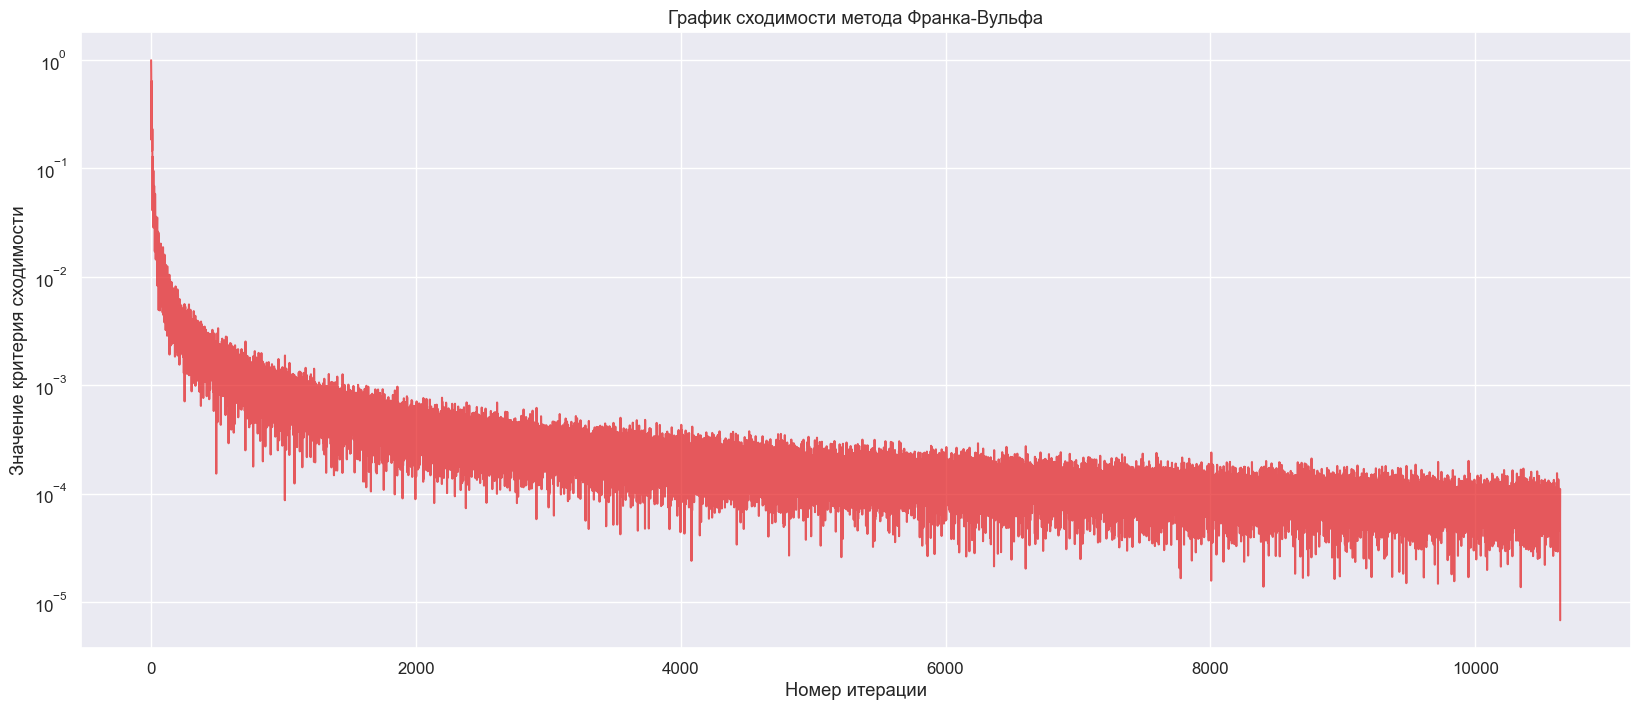

In [11]:
plt.figure(figsize=(20, 8))

plt.plot(result_frank_wolfe[1], alpha=0.7)
plt.yscale('log')
plt.title('График сходимости метода Франка-Вульфа')
plt.xlabel('Номер итерации')
plt.ylabel('Значение критерия сходимости')

plt.show()

Вывидите решение, полученный с помощью метода Франк-Вульфа. Что необычного увидели? Для большей наглядности можете воспользоваться методом Нестерова из прошлого задания и решить с помощью него безусловную задачу (на $\mathbb{R}^d$) без регуляризатора. Сделайте вывод.

In [12]:
def momentum_k(k):
    return k / (k + 3)


def nesterov_accelerated(grad, x_0, gamma_k, momentum_k, K=10**3, mode='grad(f(x_k))'):
    
    errors = []
    x_k = x_0.clone().detach()
    y_k = x_0.clone().detach()

    for k in range(K):
        x_next = y_k - gamma_k * grad(y_k)
        y_next = x_next + momentum_k(k) * (x_next - x_k)
        errors.append(torch.norm(grad(x_next)) / torch.norm(grad(x_0)))
        x_k = x_next.clone().detach()
        y_k = y_next.clone().detach()

    return x_k, errors

In [13]:
result_nesterov_accelerated = nesterov_accelerated(grad=grad_f, x_0=torch.zeros(features_amount, dtype=torch.float64), gamma_k=1/L, momentum_k=momentum_k, K=10**4)

In [14]:
print(f'Решение оптимизачионной задачи методом Франка-Вульфа:\n{result_frank_wolfe[0]}\n')
print(f'Решение оптимизачионной задачи ускоренным градиентным методом Нестерова:\n{result_nesterov_accelerated[0]}')

Решение оптимизачионной задачи методом Франка-Вульфа:
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -2.9901e-01,  0.0000e+00,  0.0000e+00, -1.0034e+00,
         0.0000e+00,  0.0000e+00,  2.0977e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -6.1780e-07,  0.0000e+00,
         1.2268e-05, -7.5109e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  5.2954e-07, -2.9047e-01,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+0

Из сравнения решений можно увидеть, что почти все компоненты решения задачи методом Франка-Вульфа равны 0, в отличие от решения ускоренным градиентным методлм Нестерова.

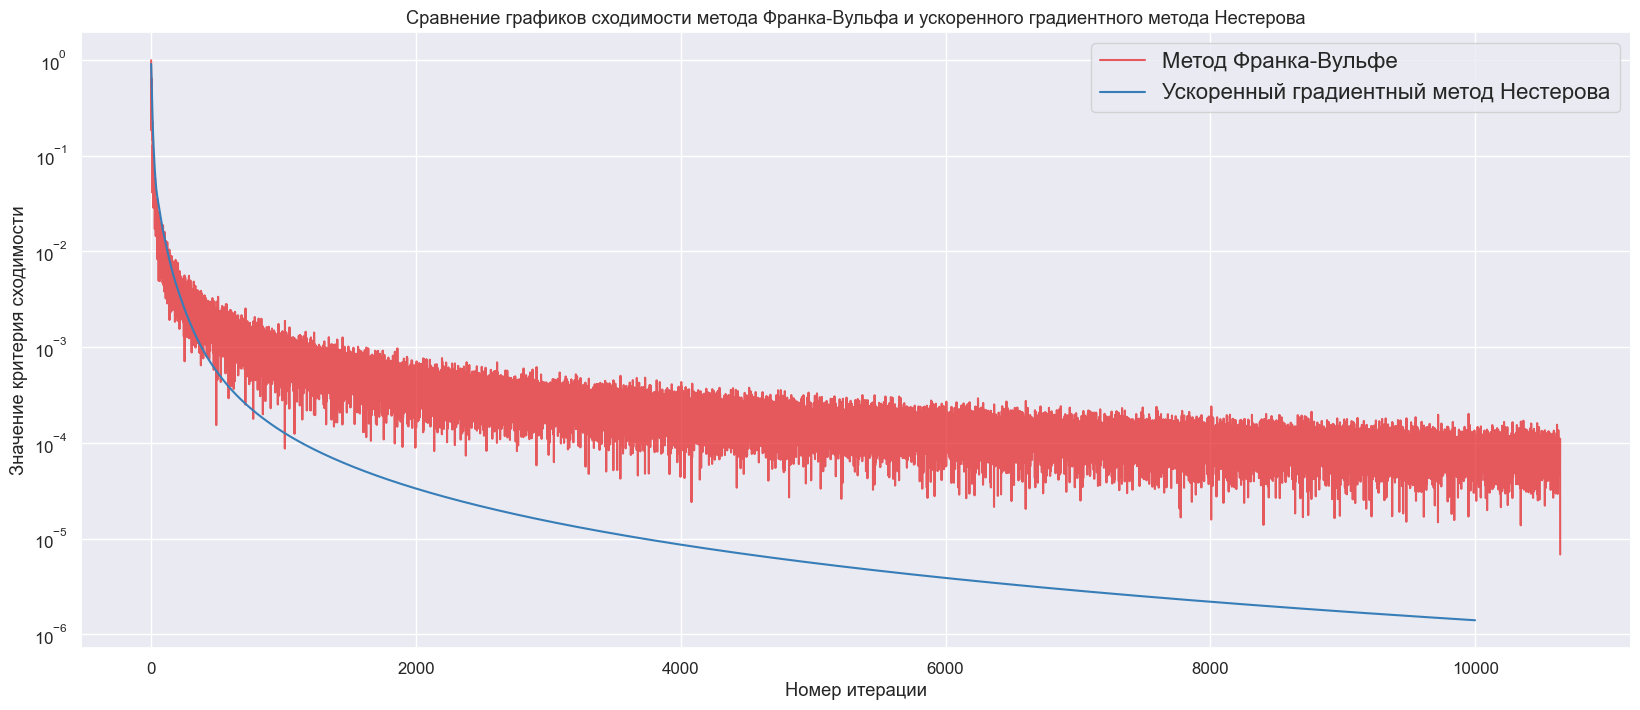

In [15]:
plt.figure(figsize=(20, 8))

plt.plot(result_frank_wolfe[1], label='Метод Франка-Вульфе', alpha=0.7)
plt.plot(result_nesterov_accelerated[1], label='Ускоренный градиентный метод Нестерова')
plt.yscale('log')
plt.title('Сравнение графиков сходимости метода Франка-Вульфа и ускоренного градиентного метода Нестерова')
plt.xlabel('Номер итерации')
plt.ylabel('Значение критерия сходимости')
plt.legend(fontsize=16)
plt.show()

Сравнив графики, можно увидеть, что они имеют разный характер сходимости - метод Франка-Вульфа, в отличие от метода Нестерова, имеет очень много скачков и при этом работает хуже и дольше. Это происходит из-за того, что решаем задачу на определенном множестве, а не на всем просранстве, как с помощью метода Нестерова.

__в). $\triangle$ (7 баллов)__ В прошлом задании мы, используя полученное решения задачи оптимизации, предсказывали ответы на тестовой выборке. Напомним суть: исходная задача регрессии является задачой машинного обучения и с помощью линейной модели $g$ можно предсказывать значения меток $y$. Пусть у нас есть сэмпл $x_i$, ответ модели для этого сэмпла есть $g(w^*, x^i)$. Тогда предсказывающее правило можно сформулировать следующим довольно естественным образом:
$$
y_i = 
\begin{cases}
1, & g(w^*, x^i) \geq 0,
\\
-1, & g(w^*, x^i) < 0.
\end{cases}
$$
Cделав предсказания на тестовой выборке $X_{test}$, можно сравните результат с реальными метками $y_{test}$. Количество правильно угаданных меток есть точность/accuracy модели.

Посмотрите какую дает модель обученная с помощью метода Франк-Вульфа. Варьируйте $R = 5, 10, 20, 50, 100, 1000$. Постройте три графика: 1) точность итоговой модели от $R$, 2) количество ненулевых компонент в итоговом решении метода Франк-Вульфа от $R$, 3) точность от количества ненулевых компонент в итоговом решении. Сделайте вывод

In [16]:
def fit(X_train, y_train):
    grad_f_fixed = functools.partial(grad_f, X=X_train, y=y_train)
    return frank_wolfe(grad=grad_f_fixed, x_0=torch.zeros(features_amount, dtype=torch.float64), R=R, eps=1e-5)[0]


def predict(X_test, w):
    y_pred = torch.sign(X_test @ w)
    y_pred[y_pred == 0] = 1
    return y_pred


def accuracy_score(y_pred, y_test):
    correctly_predicted_amount = (y_pred == y_test).sum().item()
    accuracy = correctly_predicted_amount / y_test.shape[0]
    return accuracy

In [17]:
R_list = [5, 10, 20, 50, 100, 1000]
accuracy_list = []
nonzero_components_list = []

In [18]:
for R in R_list:
    w = fit(X_train, y_train)
    nonzero_components_list.append(torch.count_nonzero(w))
    y_pred = predict(X_test, w)
    accuracy = accuracy_score(y_pred, y_test)
    accuracy_list.append(accuracy)

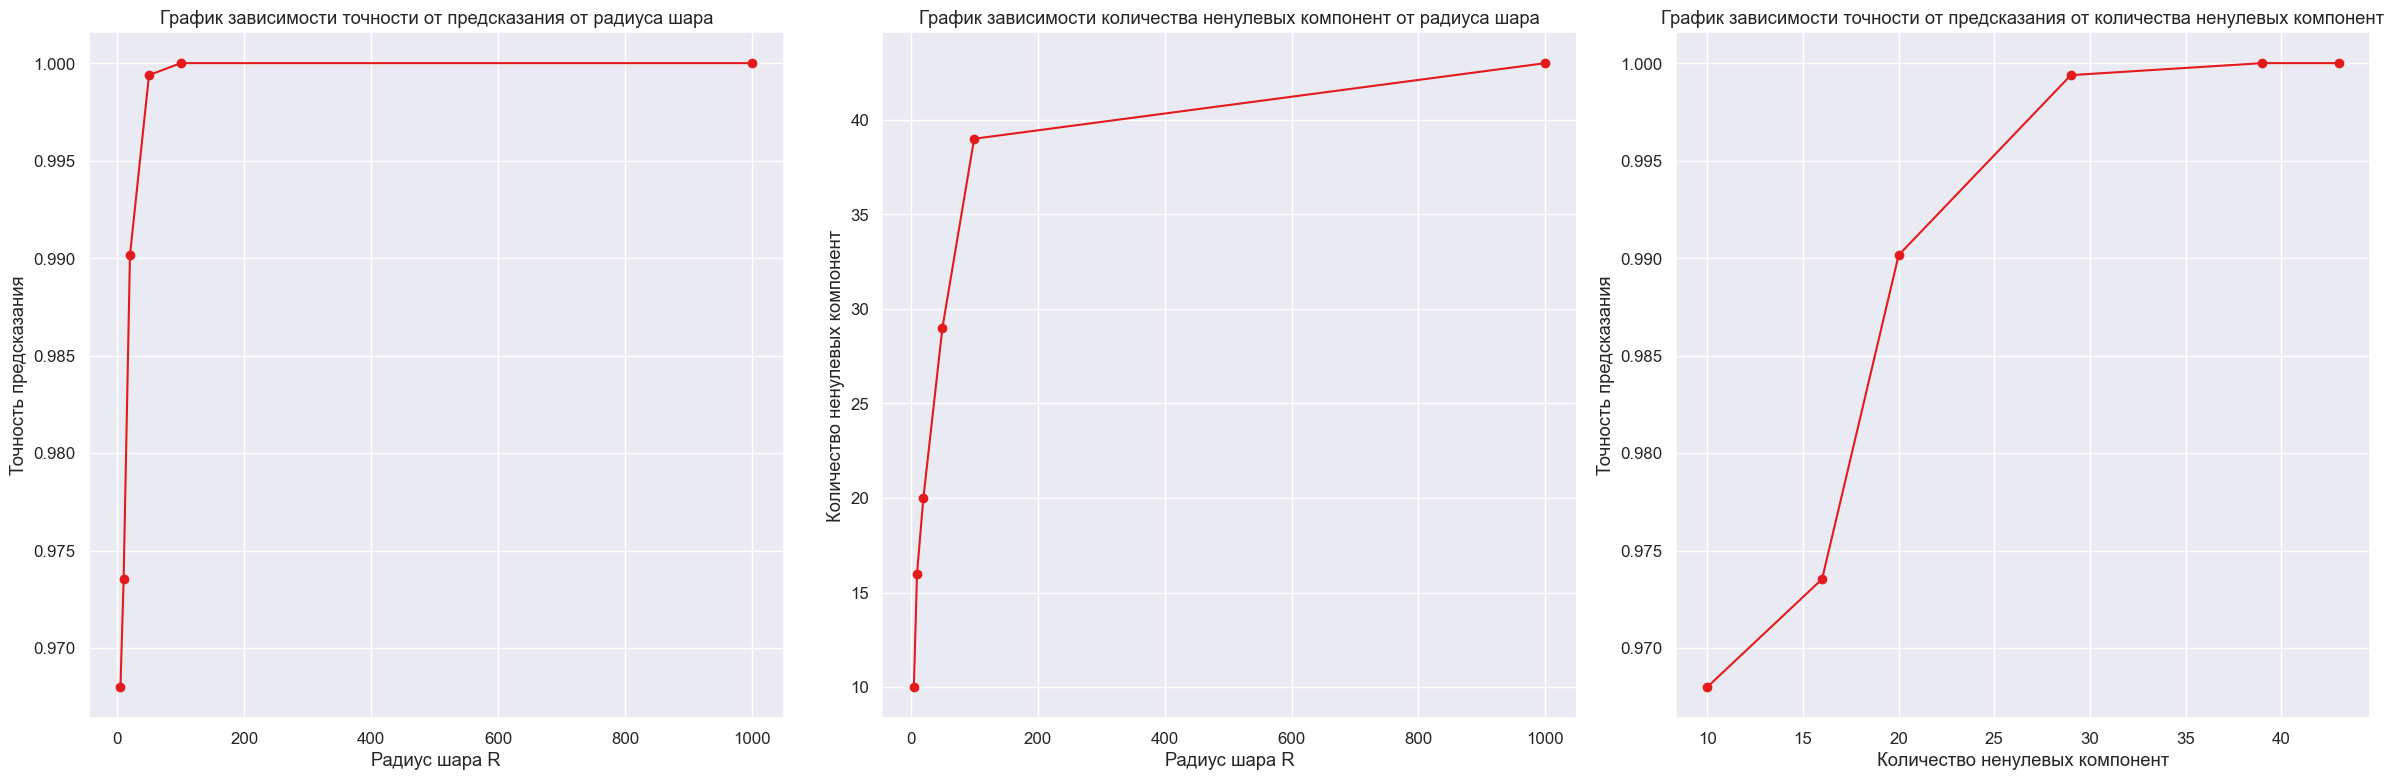

In [19]:
plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
plt.plot(R_list, accuracy_list, marker='o')
plt.xlabel('Радиус шара R')
plt.ylabel('Точность предсказания')
plt.title('График зависимости точности от предсказания от радиуса шара')

plt.subplot(1, 3, 2)
plt.plot(R_list, nonzero_components_list, marker='o')
plt.xlabel('Радиус шара R')
plt.ylabel('Количество ненулевых компонент')
plt.title('График зависимости количества ненулевых компонент от радиуса шара')

plt.subplot(1, 3, 3)
plt.plot(nonzero_components_list, accuracy_list, marker='o')
plt.xlabel('Количество ненулевых компонент')
plt.ylabel('Точность предсказания')
plt.title('График зависимости точности от предсказания от количества ненулевых компонент')

plt.tight_layout()
plt.show()

какой же можно сделать из этого вывод?

Из графиков можно сделать следующие выводы:
1. Чем больше радиус шара, тем точнее будут предсказания модели. Причем, для достижения макимальной точности досстаточно взять $R$ = 100.
2. Количество ненулевых компонент положительно зависит от радиуса шара.
3. Точность предсказания положительно зависит от количества ненулевых копмонент, что подтвердает выводы пунктов 1 и 2.

__г). $\triangle$ (15 баллов)__ Нашу задачу можнно решать и с помощью метода градиентного спуска с евклидовой проекцией. Для этого нужно уметь делать проекцию на $\ell_1$-шар. Найдите способ сделать проекцию в Интернете, достаточно загуглить: "projection onto l1 ball". Изложите здесь суть найденнного подхода (приложите ссылку откуда берете подход) и реализуйте его в коде.

Будем применять подход описанный в следующей статье: https://angms.science/doc/CVX/Proj_l1.pdf.  
Для начала изложу его суть:
1. Начнем

Решите задачу оптимизации на обучающей выборке с помощью градиентного спуска с евклидовой проекцией. Сравните на графиках сходимость градиентного спуска и метода Франк-Вульфа: 1) значение критерия от номера итерации, 2) значение критерия от времени. Сделайте вывод.

In [20]:
#ваше решение (Code и Markdown)

### Часть 2. Сопряженность. Двойственность. ККТ

__Задача 1. (15 балла)__ Для каждой из следующих функций $f$ вычислите сопряженную функцию $f^*$:

__а). (4 балла)__ $f: \mathbb{R}^d_+ \to \mathbb{R}$, где $f(x) = - \left(\prod_{i=1}^d x_i\right)^{1/d}$, а $\mathbb{R}^d_+$ - векторы с неотрицательными компонентами.

$f^*(y) = \sup_{x \in \mathbb{R}_+^d}\{x^Ty + (\prod_{i=1}^d x_i)^{1/d} \}.$

Рассмотрим случаи:
1. $\exists i: y_i > 0$: положим $x_i = t, \ x_j = 1 \ \forall j \neq i \Rightarrow x^Ty + (\prod_{i=1}^d x_i)^{1/d} = ty_i + \sum_{j = 1, \ j \neq i}^d y_i + t^{1/d} \rightarrow \infty, \ t \rightarrow \infty.$
2. $y \prec 0, \ (\prod_{i=1}^d -y_i)^{1/d} < \frac{1}{d}$: положим $x_i = -\frac{t}{y_i} \Rightarrow x^Ty + (\prod_{i=1}^d x_i)^{1/d} = -td + t(\prod_{i=1}^d -\frac{1}{y_i}))^{1/d} \rightarrow \infty, \ t \rightarrow \infty.$
3. $y \prec 0, \ (\prod_{i=1}^d -y_i)^{1/d} \geq \frac{1}{d}$: из ограничения и неравенства о средних $ (\prod_{i=1}^d x_i)^{1/d} \leq (\prod_{i=1}^d -y_ix_i)^{1/d} \leq \frac{-x^Ty}{d} \Rightarrow x^Ty + (\prod_{i=1}^d x_i)^{1/d} \leq 0 \Rightarrow \sup_{x \in \mathbb{R}_+^d}\{x^Ty + (\prod_{i=1}^d x_i)^{1/d} \} = 0.$
4. Cлучай $y_i \preceq 0, \exists i: y_i = 0$: не будем учитывать нулевые координаты и тогда будем получать аналогичные случаям 2 и 3 результаты.

Таким образом, получили:
\begin{align}
     & f^*(y) = 0, \\
     & \text{dom} f^*(y) = \{y \in R^d |y \preceq 0, \ (\prod_{i=1}^d -y_i)^{1/d} \geq \frac{1}{d}\}.
\end{align}

__б). (5 баллов)__ $f: \mathbb{R}^d \to \mathbb{R}$, где $f(x) = \max_{i=1,\dots, d}\{x_i\}$.

$f^*(y) = \sup_{x \in \mathbb{R}^d}\{x^Ty - \max_{i=1,\dots, d}\{x_i\}\}.$  
Рассмотрим случаи:
1. $y \succeq 0, \ 1_d^Ty > 1$: положим $x = t 1_d \Rightarrow x^Ty - \max_{i=1,\dots, d}\{x_i\} = t1_d^Ty - t = t(1_d^Ty - 1) \rightarrow \infty, t \rightarrow \infty.$
2. $y \succeq 0, \ 1_d^Ty < 1$: положим $x = -t 1_d \Rightarrow x^Ty - \max_{i=1,\dots, d}\{x_i\} = -t1_d^Ty + t = -t(1_d^Ty - 1) \rightarrow \infty, t \rightarrow \infty.$
3. $y \succeq 0, \ 1_d^Ty = 1 \Rightarrow x^Ty \leq \max_{i=1,\dots, d}\{x_i\} 1_d^Ty = \max_{i=1,\dots, d}\{x_i\} \Rightarrow x^Ty - \max_{i=1,\dots, d}\{x_i\} \leq 0 \Rightarrow \sup_{x \in \mathbb{R}^d}\{x^Ty - \max_{i=1,\dots, d}\{x_i\}\} = 0.$
4. $\exists i : y_i < 0$: положим $x_i = -t, \ x_j = 0 \ \forall j \neq i \Rightarrow x^Ty - \max_{i=1,\dots, d}\{x_i\} = -ty_i \rightarrow \infty, t \rightarrow \infty.$  

Таким образом, получили:
\begin{align}
     & f^*(y) = 0, \\
     & \text{dom} f^*(y) = \{y \in R^d |y \succeq 0, \ 1_d^Ty = 1\}.
\end{align}

__в). (6 баллов)__ $f: \mathbb{S}^d_{++} \to \mathbb{R}$, где $f(X) = \text{trace}(X^{-1})$ и $\mathbb{S}^d_{++}$ - положительно определенные матрицы.

$f^*(y) = \sup_{X \in \mathbb{S}_{++}^d} \{ Tr(XY) - Tr(X^{-1}) \} = \sup_{X \in \mathbb{S}_{++}^d} Tr(XY - X^{-1}).$  
Рассмотрим случаи:
1. $Y \succ 0$: воспользуемся спектральным разложением $Y = VDV^{-1}$ и положим $X = V \text{diag}(t, 1, 1, \dots 1) V^{-1} \Rightarrow Tr(XY - X^{-1}) = t \lambda_1 + \sum_{i=2}^{d} \lambda_i - \frac{1}{t} - (d - 1) \rightarrow \infty, t \rightarrow \infty.$
2. $Y \preceq 0$: $ \nabla Tr(XY - X^{-1}) = \langle Y, dx \rangle + \langle X^{-2}, dx \rangle = 0 \Rightarrow Y = -X^{-2} \Rightarrow X = -Y^{-\frac{1}{2}}.$

Таким образом, подставив найденное, получим:
\begin{align}
     & f^*(y) = -2Tr(-Y^{\frac{1}{2}}), \\
     & \text{dom} f^*(y) = \{Y | Y \preceq 0 \}.
\end{align}

__Задача 2. (4 балла)__ Построите двойственную задачу для следующей задачи оптимизации: 
\begin{align*}
        \min_{x} \ -\sum\limits_{i=1}^m \log (b_i - a_i^Tx)
\end{align*}
с областью определения $\{x \in \mathbb{R}^d \ | \ a_i^Tx < b_i \ \forall i = 1\ldots m\}$. 

_Hint:_ Сначала введите дополнительные переменные $y_i$ и ограничения $y_i = b_i - a_i^Tx$.

Введем $y_i = b_i - a_i^Tx$. Тогда будем решать следующую задачу:
\begin{align}
    & \min_{x} \ -\sum\limits_{i=1}^m \log (y_i), \\ 
    & s.t. y = b - Ax.
\end{align}

Для неё:
1. $L(x, y, \nu) = -\sum\limits_{i=1}^m \log (y_i) + \nu^T(y - b + Ax).$
2. $g(\nu) = \inf_{x, y \in \mathbb{R}^d} \{-\sum\limits_{i=1}^m \log (y_i) + \nu^T(y - b + Ax)\} =\inf_{x, y \in \mathbb{R}^d} \{-\sum\limits_{i=1}^m \log (y_i) + \langle v, y \rangle - \langle v, b \rangle + \langle A^T\nu, x \rangle \}.$
3. Рассмотрим случаи:
    1. $A^Tv \neq 0 \Rightarrow g(\nu) = -\infty, x \rightarrow - \infty.$
    2.  $A^Tv = 0, \ \nu \preceq 0 \Rightarrow g(\nu) = -\infty, y \rightarrow \infty.$
    3.  $A^Tv = 0, \ \nu \succ 0 $: рассмотрим $y_i = \frac{1}{v_i} \Rightarrow \inf_y \langle \nu, y \rangle = m \Rightarrow g(\nu) = \sum\limits_{i=1}^m \log (\nu_i) - b^T \nu + m.$  
  
Таким образом, получили двойственную задачу:
\begin{align}
    \max_{x} \ & \sum\limits_{i=1}^m \log (\nu_i)- b^T \nu + m, \\ 
    s.t. \ & A^T \nu = 0, \\
    & \nu \succ 0.
\end{align}

__Задача 3. (16 баллов)__ 
Рассмотрим задачу следующего вида: \begin{align*}
         \min_{x} \ &c^Tx\\
         \text{s.t. } &Ax \preceq b,\\
         &x_i \in \{0, 1\}, \ \forall i = 1, \ldots, d.
     \end{align*}
     Эта задачу довольно трудно решать, поэтому есть две релаксации, которые помогают построить нижнюю оценку на оптимальное значение исходной задачи.
     Рассмотрим следующие две задачи оптимизации, которые схожи с начальной:
     \begin{align*}
         \min_{x} \ &c^Tx\\
         \text{s.t. } &Ax \preceq b,\\
         &0 \leq x_i \leq 1, \ \forall i = 1, \ldots, d
     \end{align*}
     и 
     \begin{align*}
         \min_{x} \ &c^Tx\\
         \text{s.t. } &Ax \preceq b,\\
         &x_i(1 - x_i) = 0, \ \forall i = 1, \ldots, d.
     \end{align*}
     Первая задача называется LP-релаксацией исходной задачи, и, как следует из ее записи, она дает нижнюю оценку на наше исходное оптимальное значение, а вторая задача является прямой перезаписью исходной задачи.


__а). (6 баллов)__ Выпишите двойственные задачи к LP-релаксации и ко второй задаче.

Сначала найдем двойственную задачу к LP-релаксации:  
1. $L(x, \lambda) = c^Tx + \lambda_1^T(Ax-b) - \lambda_2^Tx + \lambda_3^T(x - 1_d) = (c + A^T\lambda_1 - \lambda_2 + \lambda_3)^Tx - \lambda_1^Tb - \lambda_3^T1_d.$
2. $g(\lambda) = \inf_{x} \{ (c + A^T\lambda_1 - \lambda_2 + \lambda_3)^Tx - \lambda_1^Tb - \lambda_3^T1_d \}.$
3. Рассмотрим случаи:
   1. $(c + A^T\lambda_1 - \lambda_2 + \lambda_3) \neq 0 \Rightarrow g(\lambda) = \infty, x \rightarrow \infty.$
   2. $(c + A^T\lambda_1 - \lambda_2 + \lambda_3) = 0 \Rightarrow g(\lambda) = -\lambda_1^Tb - \lambda_3^T1_d.$  

Тогда двойственная задача:
\begin{align}
    \max_{\lambda} \ & -\lambda_1^Tb - \lambda_3^T1_d, \\
    s.t. \ & c + A^T\lambda_1 - \lambda_2 + \lambda_3 = 0, \\
    & \lambda_1 \succeq 0, \ \lambda_2 \succeq 0, \ \lambda_3 \succeq 0.
\end{align}

Теперь найдем двойственную задачу ко второй задаче:
1. $L(x, \lambda \nu) = c^Tx + \lambda^T(Ax-b) + \sum_{i=1}^d\nu_i x_i - \sum_{i=1}^d\nu_i x_i^2 = (c + A^T \lambda + \nu)^T x - \lambda^T b - x^T \text{diag}(\nu) x.$
2. $g(\lambda, \nu) = \inf_{x} \{ (c + A^T \lambda + \nu)^T x - \lambda^T b - x^T \text{diag}(\nu) x \}.$
3. Рассмотрим случаи:
   1. $(c + A^T\lambda + \nu) \neq 0, \ \exists i: v_i = 0 \Rightarrow g(\lambda, \nu) = \infty, x \rightarrow \infty.$
   2. $\exists i: v_i > 0 \Rightarrow g(\lambda, \nu) = -\infty, x \rightarrow \infty.$
   3. $\nu \preceq 0: \nabla L(x, \lambda, \nu) = c + A^T\lambda + \nu - 2 \text{diag}(\nu)x = 0 \Rightarrow x_i =  \frac{1}{2\nu_i}(c + A^T + \nu)_i \Rightarrow g(\nu, \lambda) = \frac{1}{4} \sum_{i=1}^d \frac{(c + A^T\lambda + \nu)^2_i}{\nu_i} , \ \text{где} \ \nu_i = 0 \Leftrightarrow (c + A^T\lambda + \nu)_i = 0.$
  
Тогда двойственная задача:
\begin{align}
    \max_{\lambda} \ & \frac{1}{4} \sum_{i=1}^d \frac{(c + A^T\lambda + \nu)^2_i}{\nu_i} - \lambda^T b, \ \text{где} \ \nu_i = 0 \Leftrightarrow (c + A^T\lambda + \nu)_i = 0, \\
    s.t. \ & \lambda \succeq 0, \\
         & \nu \preceq 0.
\end{align}

__б). $\triangle$ (10 баллов)__ Двойственная задача ко второй задаче называется Лагранжевой релаксацией. Как следствие, она тоже дает нижнюю оценку на оптимальное значение исходной задачи. Покажите, что нижние оценки, которые вытекают из LP-релаксации и Лагранжевой релаксации, совпадают.

Сначала поработаем с двойственной задачей, полученной к перезаписи второй задачи.  

Сначала зафиксируем $\lambda$: 
1. Если $c + a_i^T\lambda \geq 0$, то так как $nu_i \leq 0$, то выражение под суммой максимально при $\nu_i = -(c_i + a_i^T\lambda)$ и равняется $0$.
2. Если $c_i + a_i^T\lambda \leq 0$, то выражение под суммой максимально при $\nu_i = c_i + a_i^T\lambda$ и равняется $4(c_i + a_i^T\lambda).$
3. Тогда $\frac{1}{4} \sum_{i=1}^d \frac{(c + A^T\lambda + \nu)^2_i}{\nu_i} = \sum_{i=1}^d \min(0, c_i + a_i^T\lambda) = 1^T \min(0, c_i + a_i^T\lambda).$

То есть получили новую задачу:
\begin{align}
    \max_{\lambda} \ & 1^T\min(0, c_i + a_i^T\lambda) - \lambda^Tb, \\
     s.t.  \ & \lambda \succeq 0.
\end{align}

Теперь рассмотрим двойственную задачу к LP-релаксации.  

Избавимся от $\lambda_2$ и получим новую задачу:
\begin{align}
    \max_{\lambda} \ & -\lambda_1^Tb - \lambda_3^T1_d, \\
    s.t. \ & c + A^T\lambda_1 + \lambda_3 = 0, \\
    & \lambda_1 \succeq 0, \ \lambda_3 \succeq 0.
\end{align}

Аналогично случаю с двойственной задачей, полученной к перезаписи второй задачи, зафиксируем $\lambda_1$:
1. Для максимизации выражения должно выполняться $\lambda_3^{i} = - \min(0, c_i + a_i^T\lambda).$

То есть получили новую задачу:
\begin{align}
    \max_{\lambda} \ & 1^T\min(0, c_i + a_i^T\lambda) - \lambda_1^Tb, \\
     s.t.  \ & \lambda_1 \succeq 0.
\end{align}

Что в точности до названия переменных совпадает с двойственной задачей, полученной к перезаписи второй задачи.

__Задача 4. $\triangle$ (8 баллов)__  

Рассмотрим следующую функцию $f: \mathbb{R}^d \to \mathbb{R}$: 
    $$
    f(x) = \sum\limits_{i=1}^r x_{[i]},
    $$
где $r$ - число от $1$ до $d$ и $x_{[1]} \geq \ldots \geq x_{[d]}$. Другими словами, это функция равна сумме $r$ наибольших компонент вектора $x$.

Покажите, что $f(x)$ равняется оптимальному значению следующей задачи оптимизации:
    \begin{align*}
        \max_{y \in \mathbb{R}^d} \ &x^Ty\\
        \text{s.t. }&0 \leq y \leq 1.\\
        &\text{1}^Ty = r.
    \end{align*}

1. Б.О.О. пусть компоненты вектора $x$ упорядочены по невозрастанию.
2. Из ограничения $1^Ty = r$ следует, что сумма компонент $y = r$.
3. Из пунктов 1-2 и ограничения $0 \leq y \leq 1$ понятно, что $y: y_1 = \ldots = y_r = 1, \ y_{r+1} = \ldots = y_d = 0$ является оптимальным (нет смысла "разбивать" компоненты $y$ для учета в скалярном произведении далее чем $r$-ую компоненту $x$(так они упорядочены по невозрастанию)).
4. Из пункта 3 получаем, что $ \max_{y \in \mathbb{R}^d} \ x^Ty = x_1 + \ldots x_r = f(x).$

Постройте двойственную задачу к задаче из предыдущего пункта (изменив задачу максимизации на задачу минимизации).

1. Перепишем исходную задачу:
\begin{align*}
        \min_{y \in \mathbb{R}^d} \ &-x^Ty\\
        \text{s.t. }&0 \leq y \leq 1.\\
        &\text{1}^Ty = r.
\end{align*}
2. Найдем Лагранжиан: $L(y, \lambda, \nu) = -x^Ty - \lambda_1^Ty + \lambda_2^T(y - 1) + \nu (1^Ty - r) = -1^T\lambda_2 - r^T\nu + (-x - \lambda_1 + \lambda_2 + \nu1)^Ty.$
3. $ g(\lambda, \nu) = inf{y \in \mathbb{R}^d} \{ -1^T\lambda_2 - r^T\nu + (-x - \lambda_1 + \lambda_2 + \nu1)^Ty \}.$
4. Рассмотрим случаи:
   1. $-x - \lambda_1 + \lambda_2 + \nu1 = 0 \Rightarrow g(\lambda, \nu) = -1^T\lambda_2 - r^T\nu.$
   2. $-x - \lambda_1 + \lambda_2 + \nu1 \neq 0 \Rightarrow g(\lambda, \nu) = \infty, \ y \rightarrow \infty.$

Тогда двойственная задача:
\begin{align}
    \max_{\lambda, \nu} \ & -1^T\lambda_2 - r^T\nu, \\
    s.t. \ & -x - \lambda_1 + \lambda_2 + \nu1 = 0, \\
    & \ \lambda, \ \nu \succeq 0.
\end{align}

__Задача 5. (4 балла)__ 
Рассмотрим следующую задачу минимизации:
\begin{align*}
    \min_{x \in \mathbb{R}^d} \ &\|Ax - b\|_2^2\\
    \text{s.t. } &Gx = h,
\end{align*}
где $A \in \mathbb{R}^{m \times d}$, $\text{rank } A = d$ и $G \in \mathbb{R}^{n \times d}$, $\text{rank }  G = n$. Выпишите ККТ для этой задачи, и найдите оптимальные значения $x^*$ и $\nu^*$ прямых и двойственных переменных соответственно.

Выпишем условия ККТ для этой задачи:
\begin{align}
    & Gx^* - h = 0, \\
    & 2A^T(Ax^* - b) + G^T\nu^* = 0.
\end{align}

Решим полученную систему уравнений:
1. Из второго уравнения $x^{*} = (A^TA)^{-1}(A^Tb - \frac{1}{2}G^T\nu^*).$
2. Подставив полученное в первое уравнение, получим: $G(A^TA)^{-1}A^Tb - \frac{1}{2}G(A^TA)^{-1}G^T\nu^* = h.$
3. Из пункта 2 получим $\nu^* = 2(G(A^TA)^{-1}G^T)^{-1}(G(A^TA)^{-1}A^Tb - h) = 2(G^T)^{-1}(A^Tb - A^TAG^{-1}h).$
4. Обратной подставновкой получим $x^* = G^{-1}h.$

__Задача 6. $\triangle$ (10 баллов)__  Рассмотрим следующую задачу оптимизации
\begin{align*}
    \min_{x} \ &f_0(x)\\
    \text{s.t. } &f_i(x) \leq 0, \ i = 1, \ldots, m,
\end{align*}
где $f_0, \ldots, f_m$ - выпуклые дифференцируемые функции.

Предположим, что $x^* \in \mathbb{R}^d$ и $\lambda^* \in \mathbb{R}^m$ удовлетворяют условиям ККТ для нашей задачи оптимизации. Выпишите условия ККТ для этой задачи и покажите, что тогда имеет место следующее неравенство:
$$\nabla f_0(x^*)^T(x - x^*) \geq 0.$$

1. Выпишем условия ККТ для этой задачи:
\begin{align}
    & f_i(x^*) \leq 0, \ i = 1 \dots m, \\
    & \lambda_i^* \geq 0, \ i = 1 \dots m, \\
    & \lambda_i^* f_i(x^*) = 0, \ i = 1 \dots m, \\
    & \nabla f_0(x^*) + \sum_{i=1}^{m} \lambda_i^* \nabla f_i(x^*) = 0.
\end{align}

2. Из выпуклости, дифференцируемости и неположительности $f_i(x)$ следует, что $f_i(x^*) + \nabla f_i(x^*)^T(x - x^*) \leq f_i(x) \leq 0, \ i = 1 \dots m.$
3. Из пункта 2 и условия неотрицательности $\lambda_i^*$ следует, что $\sum_{i=1}^{m} \lambda_i^*(f_i(x^*) + \nabla f_i(x^*)^T(x - x^*)) \leq 0.$
4. Из условий 3-4 ККТ получим: $$\sum_{i=1}^{m} \lambda_i^*(f_i(x^*) + \nabla f_i(x^*)^T(x - x^*)) = \sum_{i=1}^{m} \lambda_i^* f_i(x^*) + (\sum_{i=1}^{m} \lambda_i^* \nabla f_i(x^*))^T (x - x^*) = 0 - \nabla f_0(x^*)^T (x - x^*).$$
5. Из пунктов 3, 4 получили: $\nabla f_0(x^*)^T (x - x^*) \geq 0.$

### Часть 3. $\triangle$ Игра

На лекциях мы познакомились с экстраградиентным методом и зеркальным спуском. Первый предназначен для решения седловых задач, второй - для лучшего учета "геометрии" задачи. Попробуем объединить эти две идеи и получим следующий метод:
\begin{align}
\label{eq:1}
x^{k+1/2} &= \arg\min_{x \in \mathcal{X}} (\gamma\langle \nabla_x f(x^k, y^k), x\rangle + V(x,x^k))
\\
y^{k+1/2} &= \arg\min_{y \in \mathcal{Y}} (\gamma\langle - \nabla_y f(x^k, y^k), y\rangle + V(y,y^k))
\\
\label{eq:2}
x^{k+1} &= \arg\min_{x \in \mathcal{X}} (\gamma\langle \nabla_x f(x^{k+1/2}, y^{k+1/2}), x\rangle + V(x,x^k))
\\
y^{k+1} &= \arg\min_{y \in \mathcal{Y}} (\gamma\langle - \nabla_y f(x^{k+1/2}, y^{k+1/2}), y\rangle + V(y,y^k)),
\end{align}
где $\gamma > 0$ - шаг метода.
Для краткости введем обозначения, как на лекции:
$$
z = \binom{x}{y} \quad F(z) = F(x,y) = \binom{\nabla_x f(x, y)}{- \nabla_y f(x, y)}
$$
В новых обозначениях метод выше можно переписать, как
\begin{align}
z^{k+1/2} &= \arg\min_{z \in \mathcal{Z}} (\gamma\langle F(z^k), z\rangle + V(z,z^k))
\\
z^{k+1} &= \arg\min_{z \in \mathcal{Z}} (\gamma\langle F(z^{k+1/2}), z\rangle + V(z,z^k)).
\end{align}

Пусть оператор $F$ является $L$-Липшицевым (следует из Липшицевости градиентов):
$$
\| F(z_1) - F(z_2) \|_* \leq L \| z_1 - z_2\|,
$$
а функция $f$ является выпукло-вогнутой.

__Задача 1. $\triangle$ (10 баллов)__ Попробуем доказать сходимость данного метода, для этого понадобятся доказательства экстраградиентного метода и зеркального спуска. Объясняйте переходы там, где они кажутся неочевидными.

Для начала запишем условие оптимальности для каждой из строк рассматриваемого метода (см. как мы писали условие оптимальности в случае зеркального спуска). Для первой строки метода запишите с участие произвольной точки $u \in \mathcal{Z}$:

In [21]:
#ваше решение (Markdown)

Для второй строки метода запишите с участие произвольной точки $z \in \mathcal{Z}$:

In [22]:
#ваше решение (Markdown)

Далее воспользуемся "равенством параллелограмма" для дивергенции Брэгмана (мы его также доказывали на лекции про зеркальный спуск) и применим его к каждому из полученных выше условий оптимальности:

In [23]:
#ваше решение (Markdown)

Сложим два выражения:

In [24]:
#ваше решение (Markdown)

В качестве точки $u$ подставьте некоторую точку из алгоритма ($z^k$, $z^{k+1/2}, z^{k+1}$). Подумайте, какая точка может подойти лучше (обратите внимание на доказательство экстраградиентного метода):

In [25]:
#ваше решение (Markdown)

Проведите некоторые алгебраические преобразования с полученным неравенством, чтобы в итоге неравенство имело вид:
$\langle F(\tilde z), \tilde z - z \rangle \leq \ldots$, где $\tilde z$ - некоторая точка из алгоритма ($z^k$, $z^{k+1/2}, z^{k+1}$):

In [26]:
#ваше решение (Markdown)

Воспользуйтесь неравенством Коши-Буняковского-Шварца, чтобы далее можно воспользоваться, тем, что оператор $F$ является $L$-Липшецевым:

In [27]:
#ваше решение (Markdown)

А теперь воспользуйтесь $L$-Липшецевостью оператора $F$:

In [28]:
#ваше решение (Markdown)

Вспомните, что если дивергенция Брэгмана порождена 1-сильно выпуклой функцией, то (как уже видели на лекции) $V(x,y) \geq \frac{1}{2} \| x - y\|^2$. Воспользуйтесь этим свойством, подберите шаг $\gamma$ так, что в итоге получить результат вида: $\langle F(\tilde z), \tilde z - z \rangle \leq R_k - R_{k+1}$:

In [29]:
#ваше решение (Markdown)

Доведите доказательство до конца (смотрите доказательство экстраградиентного метода) и сформулируйте теорему о сходимости предложенного метода для выпукло-вогнутых $L$-гладких седловых задач.

In [30]:
#ваше решение (Markdown)

__Задача 2. $\triangle$ (20 баллов)__ Рассмотрим следующую билинейную задачу на симплексах:
$$
\min_{x \in \mathcal{X}} \max_{y \in \mathcal{Y}} f(x,y) = x^T A y,
$$
где $X = \{ x \in \mathbb{R}^d \mid x_i \geq 0 , \sum_{i=1}^d x_i = 1\}$, $Y = \{ y \in \mathbb{R}^d \mid y_i \geq 0 , \sum_{i=1}^d x_i = 1\}$, $A \in \mathbb{R^{d \times d}}$.

Такую задачу часто называют матричной игрой. В этом задании будет конкретная игра "Вор и полицейский".

Пусть город представляет собой квадрат из $n \times n$ маленьких квадратиков. В каждом квадратике стоит дом и полицейская будка рядом с ним. Пусть так же известны ценность дома для вора $w_{i}$ в квадрате $i$. Каждую ночь вор выбирает, какой дом ограбить, а полицейский выбирает будку, в которой будет дежурить. Вероятность поимки вора, если вор грабит дом в квадрате $i$, а полисмен дежурит в квадрате $j$ равна:
    $$\exp(- \alpha  \cdot \text{dist}(i,j)).$$ 
Здесь $\alpha > 0$ - некторый параметр, т.е. вероятность уменьшается с увеличением расстояния между квадратами.
Вор хочет максимизировать свою ожидаемую прибыль:
    $$w_i \left(1 -  \exp(- \alpha \cdot \text{dist}(i,j))\right).$$
Полицейский наоборот - минимизировать.

Такую постановку можно формализовать в виде матричной игры: занумеруем все дома от $0$ до $d = n^2 - 1$, получится вектор $w \in \mathbb{R}^{d}$ стоимостей домов. В элемент $A_{ij}$ матрицы $A$ запишем:
$$A_{ij} = w_i \left(1 - \exp(- \alpha \cdot \text{dist}(i,j))\right),$$
т.е. ожидаемую прибыль вора, если он будет грабить дом с номером $i$, а полицейский дежурить в доме с номером $j$. В векторах $x$ и $y$ будут хранится вероятностные стратегии для полицийского и вора: вероятность выбрать тот или иной дом для дежурства или грабежа. Цель задания найти равновестные стратегии. 

Возьмем $n = 10$. Следующий код генерирует некоторое распределение ценностей домов $w$ и матрицу $A$.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [32]:
def dist(i, j, n):
    i_x = i % n
    i_y = i // n
    j_x = j % n
    j_y = j // n
    return np.linalg.norm([i_x - j_x, i_y - j_y], 2)

def game(n = 10):
    i_max = (n // 2) * (n + 1)
    w = np.array([1. / (dist(i, i_max, n) + 20) for i in range(n ** 2)])
    A = np.zeros([n ** 2, n ** 2])
    for i in range(n ** 2):
        for j in range(n ** 2):
            A[i,j] = w[i] * (1 - np.exp(- dist(i, j, n)))
    return A, w

In [33]:
n = 10
A, w = game(n)

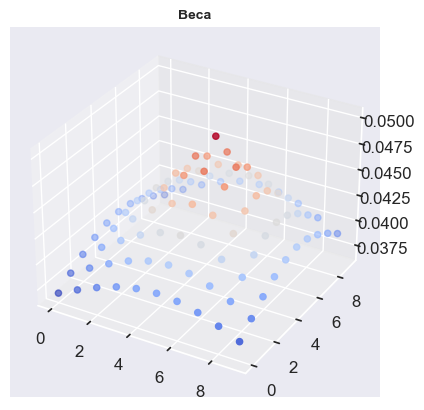

In [34]:
X, Y = np.meshgrid(range(n), range(n))
X = X.ravel()
Y = Y.ravel()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X, Y, w, c = w, cmap=cm.coolwarm)
ax.set_title(f"Веса", fontsize = 10, fontweight='bold')

plt.show()

На графике выше визуализированны стоимости домов в городе: в центре самые дорогие, на окраинах бедные.

Для игровой задачи запишите явный вид метода, для которого доказывали сходимость в Задаче 1 (на лекции мы тоже работали с симплексом). Реализуйте в виде кода.

In [35]:
#ваше решение (Code и Markdown)

Оцените константу $L$ (смотри Задачу 1) для игровой задачи. В качестве критерия используйте следующее выражение:
$$
\text{gap}(x^k, y^k) = \max_{y \in \mathcal{Y}} f(x^k, y) - \min_{x \in \mathcal{X}} f(x, y^k), \quad \text{или} \quad \text{gap}\left( \frac{1}{k} \sum_{i=0}^{k-1} x^i, \frac{1}{k}\sum_{i=0}^{k-1} y^k \right)
$$
Выпишите явный вид подсчета $\text{gap}(x^k, y^k)$ и реализуйте его (задача не зря называется билинейной).

In [36]:
#ваше решение (Code и Markdown)

С помощью реализованного метода решите игровую задачу. Рекомендуется подбирать шаг и брать его значительно больше $\frac{1}{L}$. Постройте график сходимости: значение критерия сходимости от номера итерации.

In [37]:
#ваше решение (Code и Markdown)

Визуализируйте решение $x^*$ и $y^*$ на карте города. В этом может помочь визуализация весов выше. Сделайте вывод. Насколько результат кажется натуральным и интепретируемым?

In [38]:
#ваше решение (Code и Markdown)